In [6]:
from pathlib import Path

import cv2
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [7]:
# root/
#   train/
#     REAL/
#     FAKE/
#   test/
#     REAL/
#     FAKE/

CIFAKE_ROOT = "data/"

IMAGE_EXTENSIONS = ("*.png", "*.jpg", "*.jpeg")

# LBP params
LBP_P = 8
LBP_R = 1
LBP_METHOD = "uniform"

# HOG params (for 32x32 images)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

# Gabor params
GABOR_FREQUENCIES = [0.2, 0.4]
GABOR_THETAS = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

# Color hist params
COLOR_HIST_BINS = 16

type GrayImage = NDArray[np.uint8]
type ColorImage = NDArray[np.uint8]
type FeatureVector = NDArray[np.float32]

In [8]:
# -----------------------------
# Helper: load images & labels
# -----------------------------


def load_split(split_dir: str) -> tuple[list[np.ndarray], np.ndarray]:
    """Load images and labels from split_dir (train or test).

    Assumes subfolders 'REAL' and 'FAKE'.
    Label mapping: real -> 0, fake -> 1
    """
    images = []
    labels = []

    for label_name, label_value in [("REAL", 0), ("FAKE", 1)]:
        class_dir = Path(split_dir) / label_name
        if not class_dir.is_dir():
            msg = f"Directory not found: {class_dir}"
            raise RuntimeError(msg)

        for ext in IMAGE_EXTENSIONS:
            for img_path in list(Path(class_dir).glob(ext))[:100]:
                # Load with OpenCV (BGR by default)
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label_value)

    return images, np.array(labels)


# -----------------------------
# Feature extractors
# -----------------------------


def extract_lbp_histogram(gray: GrayImage) -> FeatureVector:
    """Extract Local Binary Pattern (LBP) features - proper implementation."""
    # Manual LBP implementation for P=8, R=1, uniform pattern
    h, w = gray.shape
    lbp = np.zeros((h - 2, w - 2), dtype=np.uint8)

    # 8-neighbor offsets for radius=1
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

    for y in range(1, h - 1):
        for x in range(1, w - 1):
            center = gray[y, x]
            code = 0
            for i, (dy, dx) in enumerate(offsets):
                if gray[y + dy, x + dx] >= center:
                    code |= 1 << i

            # Check if uniform (at most 2 transitions)
            transitions = bin(code ^ (code >> 1 | (code & 1) << 7)).count("1")
            if transitions <= 2:
                lbp[y - 1, x - 1] = bin(code).count("1")  # uniform code
            else:
                lbp[y - 1, x - 1] = LBP_P + 1  # non-uniform

    # Compute histogram: uniform patterns have P+2 bins
    n_bins = LBP_P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)


def extract_hog_feature(gray: GrayImage) -> FeatureVector:
    """Extract HOG features using OpenCV to match skimage parameters."""
    h, w = gray.shape

    # Calculate window size based on image dimensions
    cell_size = HOG_PIXELS_PER_CELL
    block_size = (HOG_CELLS_PER_BLOCK[0] * cell_size[0], HOG_CELLS_PER_BLOCK[1] * cell_size[1])
    block_stride = cell_size  # Match skimage default

    # Adjust window size to be multiple of cell size
    win_w = (w // cell_size[1]) * cell_size[1]
    win_h = (h // cell_size[0]) * cell_size[0]

    if win_w != w or win_h != h:
        gray = cv2.resize(gray, (win_w, win_h))

    # Create HOG descriptor
    hog = cv2.HOGDescriptor(
        _winSize=(win_w, win_h),
        _blockSize=block_size,
        _blockStride=block_stride,
        _cellSize=cell_size,
        _nbins=HOG_ORIENTATIONS,
    )

    # Compute HOG features
    features = hog.compute(gray)
    return features.flatten().astype(np.float32)


def extract_gabor_stats(gray: GrayImage) -> FeatureVector:
    """Extract Gabor filter statistics matching skimage implementation."""
    feats = []
    gray_float = gray.astype(np.float32) / 255.0

    for freq in GABOR_FREQUENCIES:
        for theta in GABOR_THETAS:
            # Match skimage gabor filter parameters
            wavelength = 1.0 / freq
            sigma = wavelength / np.pi * np.sqrt(np.log(2) / 2) * (2**1 + 1) / (2**1 - 1)

            # Create real and imaginary Gabor kernels
            kernel_size = int(2 * np.ceil(3 * sigma) + 1)
            kernel_real = cv2.getGaborKernel(
                (kernel_size, kernel_size), sigma, theta, wavelength, 0.5, 0, ktype=cv2.CV_32F
            )
            kernel_imag = cv2.getGaborKernel(
                (kernel_size, kernel_size), sigma, theta, wavelength, 0.5, np.pi / 2, ktype=cv2.CV_32F
            )

            # Apply filters
            real_response = cv2.filter2D(gray_float, cv2.CV_32F, kernel_real)
            imag_response = cv2.filter2D(gray_float, cv2.CV_32F, kernel_imag)

            # Compute magnitude
            mag = np.sqrt(real_response**2 + imag_response**2)

            # Compute statistics
            feats.append(mag.mean())
            feats.append(mag.std())

    return np.array(feats, dtype=np.float32)


def extract_color_hist(rgb: ColorImage) -> FeatureVector:
    """Extract per-channel color histogram."""
    feats = []
    for c in range(3):  # R, G, B
        hist = cv2.calcHist([rgb], [c], None, [COLOR_HIST_BINS], [0, 256])
        hist = hist.flatten()
        hist = hist / (hist.sum() + 1e-7)  # normalize
        feats.extend(hist)
    return np.array(feats, dtype=np.float32)


# -----------------------------
# Main feature extraction
# -----------------------------


def compute_feature_groups(images: list[ColorImage]) -> dict[str, NDArray[np.float32]]:
    """Compute all feature groups for a list of images.

    images: list of RGB images
    returns: dict(feature_name -> np.array[num_samples, dim])
    """
    feature_names = ["lbp", "hog", "gabor", "color"]
    feats = {name: [] for name in feature_names}

    for img in tqdm(images, desc="Extracting features"):
        # Convert to grayscale matching skimage approach
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        feats["lbp"].append(extract_lbp_histogram(gray))
        feats["hog"].append(extract_hog_feature(gray))
        feats["gabor"].append(extract_gabor_stats(gray))
        feats["color"].append(extract_color_hist(img))

    # Stack into arrays
    for k in feats.keys():
        feats[k] = np.vstack(feats[k])

    return feats


def concat_feature_groups(feats_dict: dict[str, NDArray[np.float32]], group_names: list[str]) -> NDArray[np.float32]:
    """Concatenate selected feature groups horizontally.

    feats_dict: {name: np.array[num_samples, dim]}
    group_names: list of keys to concat
    """
    return np.hstack([feats_dict[name] for name in group_names])


# -----------------------------
# Training & evaluation
# -----------------------------


def run_experiment(
    x_train: NDArray[np.float32],
    y_train: NDArray[np.int_],
    x_test: NDArray[np.float32],
    y_test: NDArray[np.int_],
    name: str,
) -> None:
    """Train & evaluate logistic regression on given features."""
    print("\n" + "=" * 60)
    print(f"Experiment: {name}")
    print("=" * 60)

    clf = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1))])

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred, digits=4))

In [9]:
# 1. Load data
train_dir = Path(CIFAKE_ROOT) / "train"
test_dir = Path(CIFAKE_ROOT) / "test"

print("Loading training images...")
train_images, y_train = load_split(train_dir)
print("Loading test images...")
test_images, y_test = load_split(test_dir)

# 2. Feature extraction (per group)
print("\nComputing TRAIN features...")
train_feats = compute_feature_groups(train_images)
print("\nComputing TEST features...")
test_feats = compute_feature_groups(test_images)

feature_groups = ["lbp", "hog", "gabor", "color"]

# 3. Single-feature experiments (each feature alone)
for fg in feature_groups:
    X_tr = train_feats[fg]
    X_te = test_feats[fg]
    run_experiment(X_tr, y_train, X_te, y_test, name=f"{fg.upper()} only")

# 4. All features combined
all_name = "+".join(fg.upper() for fg in feature_groups)
X_train_all = concat_feature_groups(train_feats, feature_groups)
X_test_all = concat_feature_groups(test_feats, feature_groups)
run_experiment(X_train_all, y_train, X_test_all, y_test, name=f"ALL: {all_name}")

# 5. Ablation: ALL minus one group
for drop_fg in feature_groups:
    keep_groups = [fg for fg in feature_groups if fg != drop_fg]
    name = f"ALL minus {drop_fg.upper()} ({'+'.join(kg.upper() for kg in keep_groups)})"
    X_tr = concat_feature_groups(train_feats, keep_groups)
    X_te = concat_feature_groups(test_feats, keep_groups)
    run_experiment(X_tr, y_train, X_te, y_test, name=name)

Loading training images...
Loading test images...
Loading test images...

Computing TRAIN features...

Computing TRAIN features...


Extracting features: 100%|██████████| 200/200 [00:00<00:00, 549.28it/s]



Computing TEST features...


Extracting features: 100%|██████████| 200/200 [00:00<00:00, 499.41it/s]



Experiment: LBP only
              precision    recall  f1-score   support

           0     0.6579    0.7500    0.7009       100
           1     0.7093    0.6100    0.6559       100

    accuracy                         0.6800       200
   macro avg     0.6836    0.6800    0.6784       200
weighted avg     0.6836    0.6800    0.6784       200


Experiment: HOG only
              precision    recall  f1-score   support

           0     0.6579    0.7500    0.7009       100
           1     0.7093    0.6100    0.6559       100

    accuracy                         0.6800       200
   macro avg     0.6836    0.6800    0.6784       200
weighted avg     0.6836    0.6800    0.6784       200


Experiment: HOG only
              precision    recall  f1-score   support

           0     0.6842    0.6500    0.6667       100
           1     0.6667    0.7000    0.6829       100

    accuracy                         0.6750       200
   macro avg     0.6754    0.6750    0.6748       200
weighted

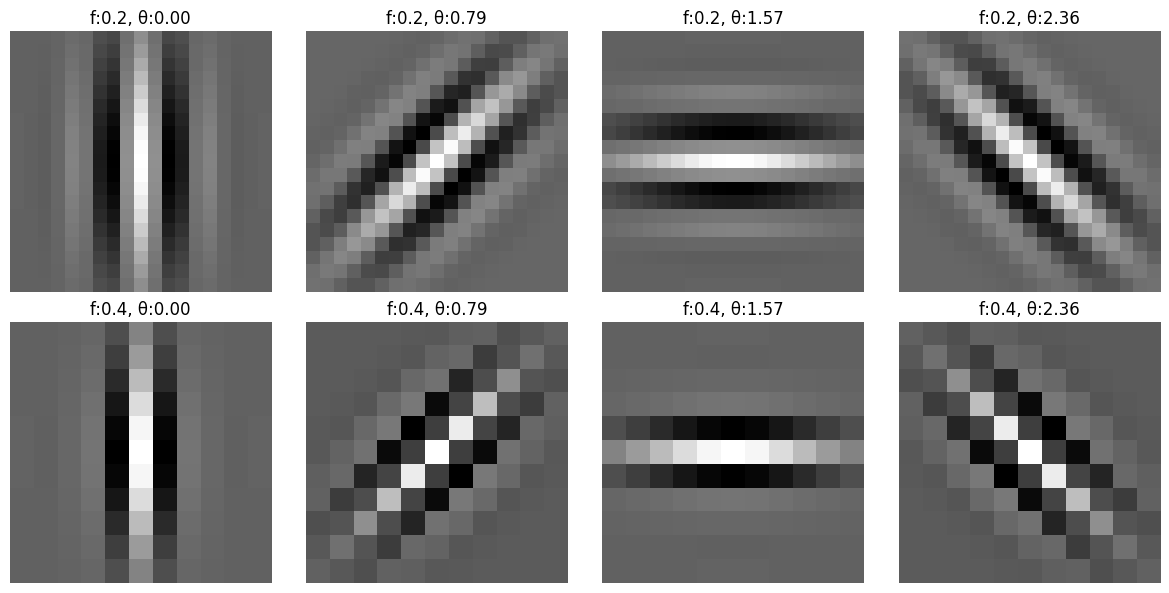

: 

In [ ]:
import matplotlib.pyplot as plt

# Visualize Gabor kernels
plt.figure(figsize=(12, 6))
i = 1

for f in GABOR_FREQUENCIES:
    wavelength = 1.0 / f
    sigma = wavelength / np.pi * np.sqrt(np.log(2) / 2) * (2**1 + 1) / (2**1 - 1)
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)

    for t in GABOR_THETAS:
        kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, t, wavelength, 0.5, 0, ktype=cv2.CV_32F)
        plt.subplot(len(GABOR_FREQUENCIES), len(GABOR_THETAS), i)
        plt.imshow(kernel, cmap="gray")
        plt.title(f"f:{f:.1f}, θ:{t:.2f}")
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()